In [7]:
import numpy as np
import pandas as pd

pd.set_option("display.precision", 3)

# some imports to set up plotting
import matplotlib.pyplot as plt

# !pip install seaborn
import seaborn as sns

# import some nice vis settings
sns.set()
# Graphics in the Retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_digits


Let’s draw some handwritten digits.

In [9]:


data = load_digits()
X, y = data.data, data.target

X[0, :].reshape([8, 8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Pictures here are 8x8 matrices (intensity of white color for each pixel). Then each such matrix is ​​“unfolded” into a vector of length 64, and we obtain a feature description of an object.

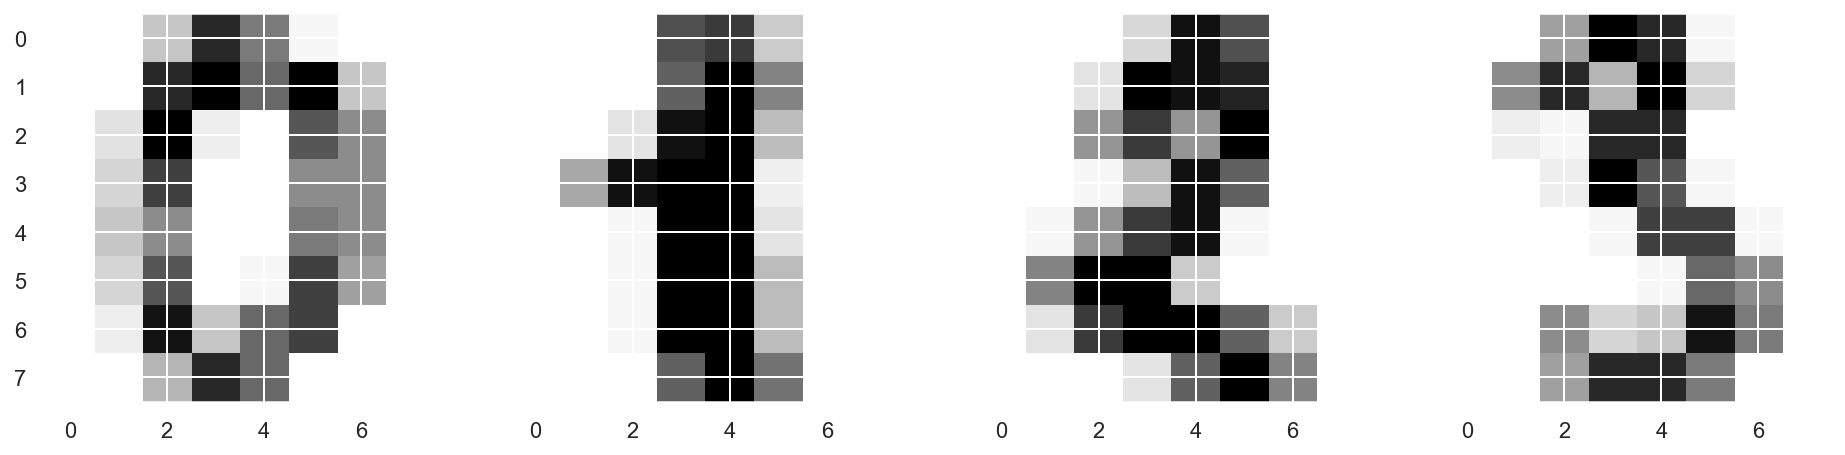

In [10]:

f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 6))
for i in range(4):
    axes[i].imshow(X[i, :].reshape([8, 8]), cmap="Greys");

70% of the dataset for training (X_train, y_train) and 30% for holdout (X_holdout, y_holdout)

The holdout set will not participate in model parameters tuning; we will use it at the end to check the quality of the resulting model.

In [12]:

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [13]:


tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=10))]
)

tree.fit(X_train, y_train)
knn_pipe.fit(X_train, y_train);